# Célula 1: Imports e Feature Engineering

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv # A camada de Rede Neural de Grafos
import geopandas as gpd
import networkx as nx
import momepy
import numpy as np
import pandas as pd
from shapely.geometry import Point


print("Bibliotecas de Deep Learning carregadas.")

# 1. Carregar Dados (Seus dados Overture tratados)
# Certifique-se de que gdf_road está na memória (do passo anterior)
# Se não estiver, carregue o GeoJSON novamente
if 'gdf_road' not in locals():
    gdf_road = gpd.read_file('../dados/brutos/overturemaps/the_bbox_segment.geojson')
    gdf_road = gdf_road.to_crs("EPSG:31983")

# --- CORREÇÃO 1: SALVAR O ORIGINAL AGORA ---
# Tiramos uma cópia segura dos dados antes de qualquer IA mexer neles
gdf_road['class_original'] = gdf_road['class'].fillna('unclassified').copy()

# 2. Criar Features Geométricas (O que define a rua?)
print("Criando características geométricas...")

# A) Comprimento Normalizado
gdf_road['length'] = gdf_road.geometry.length
gdf_road['length_norm'] = gdf_road.geometry.length # Mantemos len_norm para o GNN usar

# B) Linearidade (Reta vs Curva)
def get_linearity(geom):
    try:
        dist = Point(geom.coords[0]).distance(Point(geom.coords[-1]))
        return dist / geom.length if geom.length > 0 else 0
    except:
        return 0
gdf_road['linearity'] = gdf_road.geometry.apply(get_linearity)

# 3. Converter para Grafo (Para pegar a conectividade)
print("Convertendo para Grafo Dual (Onde cada NÓ é uma RUA)...")
# GNNs de ruas geralmente usam o "Dual Graph" ou "Line Graph":
# No grafo normal: Ruas são arestas.
# No grafo dual: Ruas viram NÓS. Se duas ruas se tocam, existe uma aresta entre elas.
# Isso permite classificar os NÓS (que são as ruas).

G_primal = momepy.gdf_to_nx(gdf_road, approach='primal')
G_dual = momepy.gdf_to_nx(gdf_road, approach='dual') # Momepy faz essa mágica

print(f"Grafo Dual criado: {len(G_dual.nodes)} ruas interconectadas.")

Bibliotecas de Deep Learning carregadas.
Criando características geométricas...
Convertendo para Grafo Dual (Onde cada NÓ é uma RUA)...
Grafo Dual criado: 66485 ruas interconectadas.


In [2]:
gdf_road.head(3)

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,...,road_surface,road_flags,speed_limits,width_rules,subclass,geometry,class_original,length,length_norm,linearity
0,6d775c41-5cf2-493e-b402-cfcbd8972262,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': 'eaaeee83-1ec8-4c2f-a46e-dde...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723376.977 9408354.072, 723403.887...",unclassified,720.449364,720.449364,0.973612
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': '89a3c9a6-e65e-4102-888f-499...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (724465.971 9415641.369, 724036.799...",unclassified,2081.823556,2081.823556,0.999003
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': 'c32213b5-fe58-4ca9-a910-32a...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723945.476 9414665.026, 723870.213...",unclassified,1099.216268,1099.216268,0.968581


In [7]:
print(f'{gdf_road.columns.tolist()}')

['id', 'version', 'sources', 'subtype', 'class', 'names', 'connectors', 'routes', 'subclass_rules', 'access_restrictions', 'level_rules', 'destinations', 'prohibited_transitions', 'rail_flags', 'road_surface', 'road_flags', 'speed_limits', 'width_rules', 'subclass', 'geometry', 'class_original', 'length', 'length_norm', 'linearity']


In [4]:
print(f'{gdf_road['class'].unique().tolist()}')

['unclassified', 'service', 'path', 'tertiary', 'primary', 'residential', 'track', 'unknown', 'secondary', 'trunk', 'footway', 'living_street', 'pedestrian', 'cycleway', 'steps', 'standard_gauge', 'light_rail', None]


# Célula: Limpeza Avançada e Extração de Atributos JSON

In [8]:
import json

print("Iniciando limpeza fina e tratamento de estruturas JSON...")

# 1. Função para extrair valor de 'road_surface'
# Estrutura esperada: [{'between': null, 'value': 'paved'}]
def extrair_superficie(valor_celula):
    try:
        # Se for nulo ou lista vazia
        if valor_celula is None or len(valor_celula) == 0:
            return 'unknown'
        
        # Se for uma lista (padrão Overture), pega o primeiro item
        if isinstance(valor_celula, list):
            primeiro_item = valor_celula[0]
            if isinstance(primeiro_item, dict):
                return primeiro_item.get('value', 'unknown')
        
        # Caso venha como string direta (raro, mas possível)
        return str(valor_celula)
    except:
        return 'unknown'

# 2. Aplicar a extração
print("Extraindo informações de superfície...")
# Cria uma coluna limpa 'surface_clean'
gdf_road['surface_clean'] = gdf_road['road_surface'].apply(extrair_superficie)

# 3. Análise de Nulos (Drop Automático de colunas inúteis)
# Vamos listar as colunas candidatas a serem mantidas, mas testar se elas têm dados
colunas_candidatas = ['road_flags', 'speed_limits', 'access_restrictions', 'width_rules']

colunas_para_manter = []

print("\n--- ANÁLISE DE DENSIDADE DE DADOS ---")
for col in colunas_candidatas:
    if col in gdf_road.columns:
        # Conta quantos NÃO são nulos e NÃO são vazios
        # Overture as vezes usa [] (lista vazia) em vez de None
        nulos = gdf_road[col].isnull().sum()
        vazios_lista = gdf_road[col].apply(lambda x: len(x) if isinstance(x, list) else 0).eq(0).sum()
        
        total_inutil = nulos + vazios_lista
        porcentagem_inutil = (total_inutil / len(gdf_road)) * 100
        
        print(f"Coluna '{col}': {porcentagem_inutil:.2f}% vazia.")
        
        # REGRA: Só mantemos se tiver pelo menos 5% de dados preenchidos
        if porcentagem_inutil < 95: 
            colunas_para_manter.append(col)
            print(f" -> MANTIDA (Contém informação relevante)")
        else:
            print(f" -> DESCARTADA (Muito ruído/vazia)")

# 4. Seleção Final de Colunas
# Montamos a lista final com o básico + as que passaram no teste + a superfície extraída
colunas_finais = [
    'id', 'subtype', 'class', 'names',          # Identificadores
    'geometry',                                 # Espacial
    'length', 'length_norm', 'linearity',       # Features Geométricas
    'class_original',                           # Rastreabilidade
    'surface_clean'                             # Superfície extraída e limpa
] + colunas_para_manter # Adiciona dinamicamente as que sobraram (se houver)

# Filtra o DataFrame
gdf_clean = gdf_road[colunas_finais].copy()

# 5. Tratamento de Nulos na Classe (Padronização)
gdf_clean['class'] = gdf_clean['class'].fillna('unknown')

print("\n--- LIMPEZA CONCLUÍDA ---")
print(gdf_clean.info())
print("\nValores de Superfície Encontrados:")
print(gdf_clean['surface_clean'].value_counts())

# Atualiza a variável principal
gdf_road = gdf_clean

Iniciando limpeza fina e tratamento de estruturas JSON...
Extraindo informações de superfície...

--- ANÁLISE DE DENSIDADE DE DADOS ---
Coluna 'road_flags': 197.27% vazia.
 -> DESCARTADA (Muito ruído/vazia)
Coluna 'speed_limits': 180.72% vazia.
 -> DESCARTADA (Muito ruído/vazia)
Coluna 'access_restrictions': 160.17% vazia.
 -> DESCARTADA (Muito ruído/vazia)
Coluna 'width_rules': 198.01% vazia.
 -> DESCARTADA (Muito ruído/vazia)

--- LIMPEZA CONCLUÍDA ---
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66486 entries, 0 to 66485
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   id              66486 non-null  object  
 1   subtype         66486 non-null  object  
 2   class           66486 non-null  object  
 3   names           43852 non-null  object  
 4   geometry        66486 non-null  geometry
 5   length          66486 non-null  float64 
 6   length_norm     66486 non-null  float64 
 7   linea

# Célula 2: Transformação em Tensores PyTorch

In [10]:
gdf_road.head()

,id,subtype,class,names,geometry,length,length_norm,linearity,class_original,surface_clean
0,6d775c41-5cf2-493e-b402-cfcbd8972262,road,unclassified,None,"LINESTRING (723376.977 9408354.072, 723403.887...",720.449364,720.449364,0.973612,unclassified,unpaved
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,road,unclassified,None,"LINESTRING (724465.971 9415641.369, 724036.799...",2081.823556,2081.823556,0.999003,unclassified,unpaved
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,road,unclassified,None,"LINESTRING (723945.476 9414665.026, 723870.213...",1099.216268,1099.216268,0.968581,unclassified,unpaved
3,7b0e2bea-3908-4ba4-93da-6f9ff6f06056,road,unclassified,None,"LINESTRING (726129.04 9412722.319, 726055.54 9...",540.386635,540.386635,0.999254,unclassified,unpaved
4,87309c7e-7195-4237-9d45-42570008a3b4,road,unclassified,None,"LINESTRING (726305.053 9412149.253, 726254.563...",665.671536,665.671536,0.779061,unclassified,unpaved


In [11]:
# Célula 2 (Atualizada): Feature Engineering Híbrida e Tensores
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

print("Codificando features híbridas (Geometria + Superfície)...")

# 1. Preparar Rótulos (Target - O que queremos descobrir)
# (Mantemos a mesma lógica de antes)
classes_validas = [
    'motorway', 'trunk', 'primary', 'secondary', 'tertiary', 
    'residential', 'living_street', 'service', 'pedestrian', 'footway',
    'track' # Adicionei track pois superfície ajuda muito aqui
]

le = LabelEncoder()
le.fit(classes_validas)

def encode_target(val):
    if val in classes_validas:
        return le.transform([val])[0]
    return -1

gdf_road['y_encoded'] = gdf_road['class'].apply(encode_target)

# 2. Preparar FEATURES (O X da questão)

# Parte A: Numéricas (Geometria)
# Normalizamos para que o comprimento (ex: 500m) não "engula" a linearidade (0 a 1)
features_numericas = gdf_road[['length_norm', 'linearity']].values
scaler = StandardScaler()
X_num = scaler.fit_transform(features_numericas)

# Parte B: Categóricas (Superfície)
# Transforma 'paved' em [1, 0] e 'unpaved' em [0, 1]
encoder_surf = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
surface_data = gdf_road[['surface_clean']].values
X_cat = encoder_surf.fit_transform(surface_data)

print(f"Features de Superfície geradas: {encoder_surf.get_feature_names_out(['surface_clean'])}")

# Parte C: Combinação (Concatenação)
# Juntamos Geometria + Superfície numa matriz só
X_final = np.hstack([X_num, X_cat])

# Converte para Tensor PyTorch
x = torch.tensor(X_final, dtype=torch.float)

print(f"Dimensão final das Features (Input): {x.shape[1]} colunas")
# Guarde esse número! (x.shape[1]). Precisaremos dele na definição do Modelo.

# 3. Estrutura do Grafo (Arestas)
# (Lógica idêntica à anterior, convertendo Grafo Dual)
G_dual = momepy.gdf_to_nx(gdf_road, approach='dual')
G_dual_int = nx.convert_node_labels_to_integers(G_dual)
pyg_graph = from_networkx(G_dual_int)
edge_index = pyg_graph.edge_index

# 4. Máscaras e Objeto Final
y = torch.tensor(gdf_road['y_encoded'].values, dtype=torch.long)
train_mask = y != -1
predict_mask = y == -1

data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.predict_mask = predict_mask

print("Dados prontos! O modelo agora enxerga geometria E tipo de piso.")

Codificando features híbridas (Geometria + Superfície)...
Features de Superfície geradas: ['surface_clean_dirt' 'surface_clean_gravel' 'surface_clean_paved'
 'surface_clean_paving_stones' 'surface_clean_unknown'
 'surface_clean_unpaved']
Dimensão final das Features (Input): 8 colunas
Dados prontos! O modelo agora enxerga geometria E tipo de piso.


# Célula 3: Definição e Treinamento do Modelo

In [12]:
# 1. Definir a Arquitetura da Rede Neural
class StreetClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        # Primeira camada de convolução (olha vizinhos imediatos)
        self.conv1 = GCNConv(num_features, 16)
        # Segunda camada (olha vizinhos dos vizinhos)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Camada 1 + Ativação ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # Evita decorar dados (overfitting)

        # Camada 2
        x = self.conv2(x, edge_index)

        # Saída: Probabilidade de ser cada classe (Log Softmax)
        return F.log_softmax(x, dim=1)

# 2. Inicializar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = StreetClassifier(num_features=2, num_classes=len(classes_validas)).to(device) # fixo
# AGORA DEVE SER DINÂMICO:
num_features_input = data.num_node_features # O PyG calcula sozinho baseado no tensor x
model = StreetClassifier(num_features=num_features_input, num_classes=len(classes_validas)).to(device)
#
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print("Iniciando treinamento (Isso pode levar alguns segundos)...")

# 3. Loop de Treinamento
model.train()
for epoch in range(200): # 200 épocas (passadas)
    optimizer.zero_grad()
    out = model(data)
    
    # Calcula erro apenas nas ruas conhecidas (Train Mask)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Época {epoch}: Erro (Loss) = {loss.item():.4f}")

print("Treinamento Concluído!")

Iniciando treinamento (Isso pode levar alguns segundos)...
Época 0: Erro (Loss) = 2.3085
Época 20: Erro (Loss) = 1.1564
Época 40: Erro (Loss) = 1.0099
Época 60: Erro (Loss) = 0.9755
Época 80: Erro (Loss) = 0.9622
Época 100: Erro (Loss) = 0.9540
Época 120: Erro (Loss) = 0.9477
Época 140: Erro (Loss) = 0.9414
Época 160: Erro (Loss) = 0.9382
Época 180: Erro (Loss) = 0.9355
Treinamento Concluído!


# Célula 4: Predição e Exportação

In [17]:
# Célula 4: Predição e Exportação (Ajustada)

model.eval() # Modo de avaliação
_, pred = model(data).max(dim=1) # Pega a classe com maior probabilidade

# Recupera os nomes das classes (número -> texto)
pred_classes = le.inverse_transform(pred.cpu().numpy())

# Atualiza o GeoDataFrame
print("Aplicando predições...")

# Cria coluna nova
gdf_road['class_ml_gnn'] = gdf_road['class']

# Onde era desconhecido (predict_mask), coloca o valor predito
mask_np = data.predict_mask.cpu().numpy()
gdf_road.loc[mask_np, 'class_ml_gnn'] = pred_classes[mask_np]

# Substitui a coluna oficial para usarmos no cálculo de velocidade
gdf_road['class'] = gdf_road['class_ml_gnn']

print("Classificação via GNN finalizada.")
print("\nExemplo de ruas 'unclassified' que foram classificadas:")

# --- AJUSTE AQUI (Nome da coluna corrigido para 'length_norm') ---
# Verificamos quais colunas existem para evitar erro
cols_para_ver = ['id', 'length_norm', 'class']
# Se por acaso 'length_norm' não existir, tenta 'length' ou 'len_norm'
if 'length_norm' not in gdf_road.columns:
    if 'len_norm' in gdf_road.columns: cols_para_ver[1] = 'len_norm'
    elif 'length' in gdf_road.columns: cols_para_ver[1] = 'length'

print(gdf_road[mask_np][cols_para_ver].head(10))

Aplicando predições...
Classificação via GNN finalizada.

Exemplo de ruas 'unclassified' que foram classificadas:
                                     id  length_norm        class
0  6d775c41-5cf2-493e-b402-cfcbd8972262   720.449364  residential
1  aec4047f-e9b3-4c2b-ba48-c1c065ffc97e  2081.823556  residential
2  fabe85df-cfbc-4adc-a6e7-7a41c44f39c6  1099.216268  residential
3  7b0e2bea-3908-4ba4-93da-6f9ff6f06056   540.386635  residential
4  87309c7e-7195-4237-9d45-42570008a3b4   665.671536        track
5  4797c7d7-c1bf-4919-95c9-b5a036922ae0   973.132207  residential
6  7327becf-7849-420c-84dc-a397faeafc76    57.470799  residential
7  31516b8b-452e-44cc-8a4d-914b0a0bfe5d  3354.665865  residential
8  03066505-ac3f-4fe4-bff6-7ca75579a32f  1468.727184  residential
9  1adc41b1-2057-4f0c-9234-19a8b2a248b9    97.219294  residential


In [19]:
gdf_road.head()

,id,subtype,class,names,geometry,length,length_norm,linearity,class_original,surface_clean,y_encoded,class_ml_gnn
0,6d775c41-5cf2-493e-b402-cfcbd8972262,road,residential,None,"LINESTRING (723376.977 9408354.072, 723403.887...",720.449364,720.449364,0.973612,unclassified,unpaved,-1,residential
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,road,residential,None,"LINESTRING (724465.971 9415641.369, 724036.799...",2081.823556,2081.823556,0.999003,unclassified,unpaved,-1,residential
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,road,residential,None,"LINESTRING (723945.476 9414665.026, 723870.213...",1099.216268,1099.216268,0.968581,unclassified,unpaved,-1,residential
3,7b0e2bea-3908-4ba4-93da-6f9ff6f06056,road,residential,None,"LINESTRING (726129.04 9412722.319, 726055.54 9...",540.386635,540.386635,0.999254,unclassified,unpaved,-1,residential
4,87309c7e-7195-4237-9d45-42570008a3b4,road,track,None,"LINESTRING (726305.053 9412149.253, 726254.563...",665.671536,665.671536,0.779061,unclassified,unpaved,-1,track


# Célula: Estatísticas Comparativas (Validação do Modelo)

Gerando estatísticas de validação...


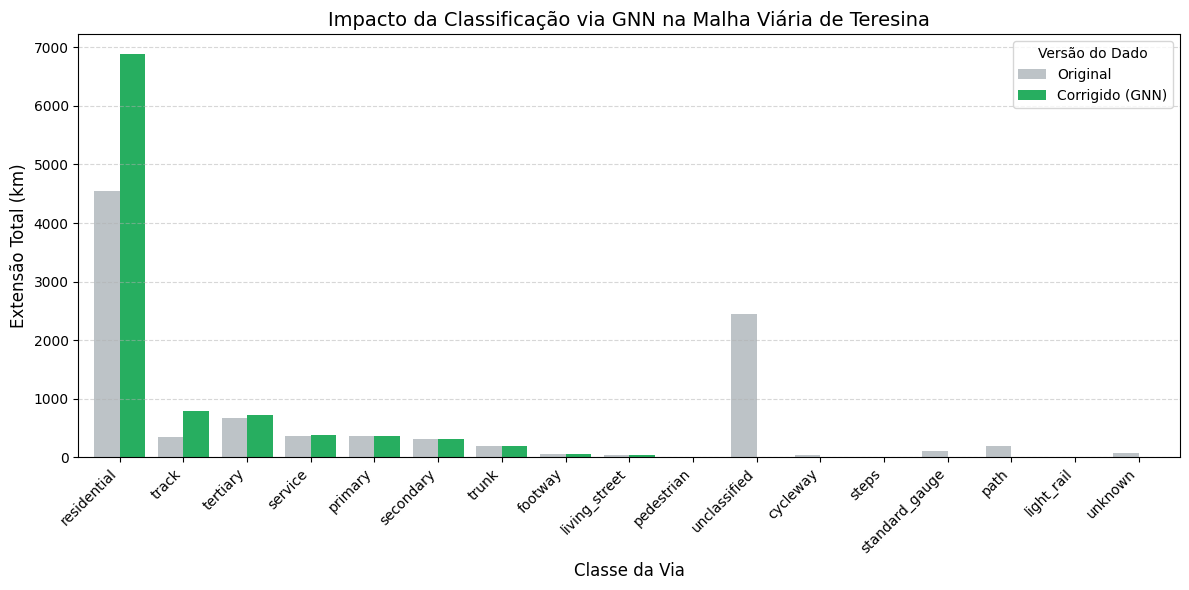


--- RESUMO DA MUDANÇA (em KM) ---
residential       2325.632638
track              441.554265
tertiary            49.419420
service             19.500266
unclassified     -2444.361131
cycleway           -29.735894
steps               -0.484185
standard_gauge    -105.989443
path              -184.293470
light_rail          -7.676152
unknown            -63.566313
dtype: float64


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Gerando estatísticas de validação...")

# 1. Preparar dados para comparação
# Vamos somar a quilometragem por classe (mais relevante que contagem de linhas)
stats_antes = gdf_road.groupby('class_original')['length_norm'].sum() / 1000 # em KM
stats_depois = gdf_road.groupby('class_ml_gnn')['length_norm'].sum() / 1000       # em KM

# Cria um DataFrame único para plotagem
df_stats = pd.DataFrame({'Original': stats_antes, 'Corrigido (GNN)': stats_depois}).fillna(0)

# Ordena para ficar bonito no gráfico (do maior para o menor no corrigido)
df_stats = df_stats.sort_values(by='Corrigido (GNN)', ascending=False)

# 2. Visualização Gráfica
fig, ax = plt.subplots(figsize=(12, 6))

df_stats.plot(kind='bar', ax=ax, width=0.8, color=['#bdc3c7', '#27ae60'])

plt.title("Impacto da Classificação via GNN na Malha Viária de Teresina", fontsize=14)
plt.ylabel("Extensão Total (km)", fontsize=12)
plt.xlabel("Classe da Via", fontsize=12)
plt.legend(title="Versão do Dado")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 3. Printar números absolutos para você citar no texto
print("\n--- RESUMO DA MUDANÇA (em KM) ---")
diff = df_stats['Corrigido (GNN)'] - df_stats['Original']
print(diff[diff != 0]) # Mostra apenas o que mudou

In [21]:
gdf_road.to_file("../dados/processados/overturemaps/the_bbox_om_segments_gnn.gpkg", driver="GPKG" ,layer='the_bbox_om_segments_gnn')